# Set-up

## Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#Inverse and determinant of a matrix
from numpy.linalg import inv, det

# to time procedure
import time

# import gamma, beta incomplete inverse and beta incomplete
from scipy.special import gamma, betaincinv, betainc
import seaborn as sns
%matplotlib inline

## display settings 

In [3]:
%%HTML
# https://stackoverflow.com/questions/49888173/python-jupyter-notebook-print-dataframe-borders
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Import Data

In [4]:
path = r"..\\2022\\2. Data\\"
path_image = r"..\\2022\1. LaTeX\\Image\\"

cds_spread = pd.read_csv(path+"20180620_snapshot.csv").iloc[:,1:]#.set_index("Company")
# cds_5y = pd.read_csv(path+"5YCDS.csv").iloc[:,1:]
#equity_daily = pd.read_csv(path + "equity.csv") # used to check functions
# equity_weekly = pd.read_csv(path + "equities_1wk.csv")
# equity_monthly  = pd.read_csv(path + "equities_1mo.csv")
#discount = pd.read_excel(path+"20180620_DiscountFactor.xlsx").iloc[:,1:]
discounts = pd.read_csv(path+"20180620_DiscountFactor_bloomberg_interpolated.csv").iloc[:,1:]


names = ["AAL", "ALLY", "AMD", "AMKR", "F"]
cds_spread.index = names

#Pseudo samples from Matlab
u_hat = pd.read_csv(path+"Pseudo_samples.csv").iloc[:,1:]

### ZCB
Define a zcb function

In [5]:
def zcb(T):
    """
    input : T: Scalar : Maturity
    -----------------------------
    Output: Zero Coupon Bond <==> Discount Factor
    -----------------------------
    NB: in this case, t: 0. 
    Therefore, there is no need to explicitly call it. 

    """
    if T > np.max(discounts.loc[:,"T"]):
        return np.min(discounts.loc[:,"DF"])
    return linear_interpolation(discounts.loc[:,"T"], discounts.loc[:,"DF"],T)

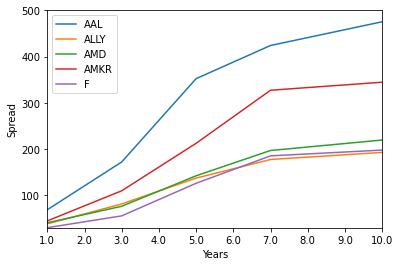

In [6]:
for i in names:
    plt.plot(cds_spread.columns, cds_spread.loc[i, :], label=i)

plt.xlabel("Years")
plt.xlim(1,10)
plt.ylabel("Spread")
plt.ylim(30,500)
plt.legend()
#plt.savefig(path_image+'CDS Spreads.png')

In [7]:
cds_spread

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
AAL,0.0,69.09,120.720,172.35,262.375,352.40,388.230,424.06,441.153333,458.246667,475.34
ALLY,0.0,38.51,60.035,81.56,109.500,137.44,157.560,177.68,182.790000,187.900000,193.01
AMD,0.0,40.85,58.695,76.54,109.495,142.45,169.780,197.11,204.640000,212.170000,219.70
AMKR,0.0,44.94,77.475,110.01,161.355,212.70,270.015,327.33,333.113333,338.896667,344.68
F,0.0,30.30,43.040,55.78,91.015,126.25,155.880,185.51,189.670000,193.830000,197.99


In [8]:
# We only need the first 5 years for our purpose
cds_spread = cds_spread.iloc[:,:6]

## Constants

In [10]:
# Value of pi taken from: 
# http://www.math.com/tables/constants/pi.htm#:~:text=3.1415926535%208979323846%202643383279%205028841971%206939937510%205820974944%205923078164%200628620899%208628034825%203421170679%20...&text=PI%2F4%20%3D%201%2F1,1%2F7%20%2B%20...&text=PI%2F2%20%3D%202%2F1,6%2F7%20*%20...
pi = 3.1415926535897932384626433832795028841971693993751058209749445923078164
pi

3.141592653589793

In [11]:
# value of e taken from:
# https://www.math.utah.edu/~pa/math/e.html
e = 2.7182818284590452353602874713526624977572470936999595749669676277240766
e

2.718281828459045

## Functions

Defining a function for a standard normal distribution make the calculation more efficient. 


(i.e. Python does not need to input a value for $\mu$ and $\sigma$ as they are defined by 0 and 1 respectively)

### Gaussian

#### Norm pdf

In [12]:
def norm_pdf(x):
    """
    Standard normal probability density function
    """
    return (1.0/((2*pi)**0.5))*np.exp(-0.5*x**2)

#### Norm cdf

In [13]:
def norm_cdf(x):
    """
    Norm CDF function # Wilmott Magazine, p 70-76, May 2005 # Graeme West
    Hart (1968)
    """
    x_abs = abs(x)
    
    if x_abs > 37:
        norm_cdf = 0
    else:
        exp_abs = e**(-0.5*x_abs**2)
        
        if x_abs < 7.07106781186547:
            k_temp = 3.52624965998911E-02 * x_abs + 0.700383064443688
            k_temp = k_temp * x_abs + 6.37396220353165
            k_temp = k_temp * x_abs + 33.912866078383
            k_temp = k_temp * x_abs + 112.079291497871
            k_temp = k_temp * x_abs + 221.213596169931
            k_temp = k_temp * x_abs + 220.206867912376
            
            
            norm_cdf = exp_abs * k_temp        
            
            
            k_temp = 8.83883476483184E-02 * x_abs + 1.75566716318264
            k_temp = k_temp * x_abs + 16.064177579207
            k_temp = k_temp * x_abs + 86.7807322029461
            k_temp = k_temp * x_abs + 296.564248779674
            k_temp = k_temp * x_abs + 637.333633378831
            k_temp = k_temp * x_abs + 793.826512519948
            k_temp = k_temp * x_abs + 440.413735824752
            norm_cdf = norm_cdf / k_temp
            
            
            
        else:
            k_temp = x_abs + 0.65
            k_temp = x_abs + 4 / k_temp
            k_temp = x_abs + 3 / k_temp
            k_temp = x_abs + 2 / k_temp
            k_temp = x_abs + 1 / k_temp
            norm_cdf = exp_abs / k_temp / 2.506628274631

    if x > 0:
        norm_cdf = 1 - norm_cdf

    return norm_cdf
    

##### Vectorisation

The vectorize function is provided primarily for convenience, not for performance. The implementation is essentially a for loop.


https://numpy.org/doc/stable/reference/generated/numpy.vectorize.html

In [14]:
# vectorise norm_cdf function
norm_cdf_v = np.vectorize(norm_cdf)

#### Norm Inv

In [15]:
def norm_inv(p):
#   Onverse normal algorithm developed by
#   P. J. Acklam.  It is accurate to 1.15E-9.
#   Could not find the original paper online. # Website link does not exist anymore. 
#   Used this as a reference. https://stackedboxes.org/2017/05/01/acklams-normal-quantile-function/

    #Define constants
    a1  = -39.6968302866538   
    a2  = 220.946098424521     
    a3  = -275.928510446969    
    a4  = 138.357751867269     
    a5  = -30.6647980661472    
    a6  = 2.50662827745924    
    
    b1  = -54.4760987982241     
    b2  = 161.585836858041     
    b3  = -155.698979859887    
    b4  = 66.8013118877197     
    b5  = -13.2806815528857    
    
    c1  = -7.78489400243029*10**(-3) 
    c2  = -0.322396458041136    
    c3  = -2.40075827716184     
    c4  = -2.54973253934373    
    c5  = 4.37466414146497      
    c6  = 2.93816398269878      
    
    d1  = 7.78469570904146*10**(-3)  
    d2  = 0.32246712907004      
    d3  = 2.445134137143        
    d4  = 3.75440866190742 
    
    #Define break points
    p_lower  = 0.02425 # lower bound
    p_upper  = 1 - p_lower  # upper bound
    
    
    if (0 < p < p_lower): #Rational approximation for lower region
        q = (-2 * np.log(p))**0.5
        norm_inverse = (((((c1 * q + c2) * q + c3) * q + c4) * q + c5) * q + c6) / ((((d1 * q + d2) * q + d3) * q + d4) * q + 1)
        
    elif (p_lower <p< p_upper): #Rational approximation for central region
        q = p - 0.5
        r = q * q
        norm_inverse = (((((a1 * r + a2) * r + a3) * r + a4) * r + a5) * r + a6) * q /(((((b1 * r + b2) * r + b3) * r + b4) * r + b5) * r + 1)
    elif (p_upper < p) and (p < 1): #Rational approximation for upper region
        q = (-2 * np.log(1 - p))**0.5
        norm_inverse = -(((((c1 * q + c2) * q + c3) * q + c4) * q + c5) * q + c6) /((((d1 * q + d2) * q + d3) * q + d4) * q + 1)
    else: #Out of valid region
        norm_inverse = np.log(-1) #invalid value

        
    return norm_inverse

In [16]:
# vectorise norm_cdf function
norm_inv_v = np.vectorize(norm_inv)

### t-student

#### Beta functions

In [17]:
def beta(a,b):
     
    '''
    uses gamma function  to compute values of beta function
    ------------------------------------
    source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.beta.html
    '''
     
    return gamma(a)*gamma(b)/gamma(a+b)
    

In [18]:
def beta_inc_lower(a,b,x):
    
    """
    lower incomplete beta function: 
    require: scipy.special.betainc 
    -------------------------------
    https://mathworld.wolfram.com/IncompleteBetaFunction.html
    """

    return betainc(a,b,x)* beta(a,b)
    


#### PDF

In [19]:
def t_student_pdf(t, nu):
    a = (nu+1)/2
    
    return gamma(a)/(np.sqrt(nu*pi)*gamma(nu/2))*(1+t**2/nu)**(-a)

#### CDF

In [20]:
def t_student_cdf(x, nu):
    
    """
    t_student cdf:
    ------------------------
    input: x : nx1 array
           ny: degree of freedom 
    """
    
    x = np.array(x)
    x = x.reshape(-1,1)
    c = nu / (nu+x**2)  
    #cdf =  0.5 * rl_beta_inc(nu/2, 0.5, c)
    cdf =  0.5 * betainc(nu/2, 0.5, c)
    
    # psi(x) = 1-psi(-x)
    # please note x**2 = (-x)**2
    # hence we can just return 1-cdf
    cdf = cdf.T
    return np.select(x.T <=np.zeros_like(x.T), cdf, 1-cdf).T
#     if x <=0:
#         return cdf
#     else: 
#         return 1-cdf

#### Inverse

In [21]:
def t_student_inv(p, nu):
    """
    input: nx1 array
           nu: scalar: degree of freedom
    ----------------------------------------
    output: nx1 array
    ----------------------------------------
    Source: MyTINV p17: T COPULA and degrees of freedom \nu (MLE PROCEDURE GUIDE)
    
    Formula coherent with 
    https://www.wolframalpha.com/input/?i=inverse+cdf+student%27s+t+distribution    
    """
    p = np.array(p).reshape(-1,1)
    
        
        
    var = np.minimum(p, 1-p)
    temp = betaincinv( nu/2, 0.5, 2*var)
    try:
        temp = 1/temp
    except (RuntimeError, RuntimeWarning):
        print("Oops!  Dividing by 0 !?")
        temp =np.inf
    
    x = np.sign(p-0.5)*(nu*(temp-1))**0.5
    return x

#### Check

Import t module from scipy.stats to check if function correcly implemented

In [23]:
from scipy.stats import t

In [24]:
f1 = lambda x, nu: t.pdf(x,nu) - t_student_pdf(x, nu)
f2 = lambda x, nu: t.cdf(x,nu) - t_student_cdf(x, nu)
f3 = lambda x, nu: t.ppf(x,nu) - t_student_inv(x, nu)

In [25]:
error_pdf = 0.0
for i in np.arange(-3,3, 0.001):
    for j in range(1,25):
        error_pdf+=f1(i,j)**2
print("Sum error squared of pdf: ", error_pdf)

Sum error squared of pdf:  2.9783872658070345e-27


In [26]:
error_cdf = 0.0
for i in np.arange(-2,2, 0.001):
    for j in range(1,25):
        error_cdf+=f2(i,j)
print("Sum error squared of cdf: ", error_cdf)

Sum error squared of cdf:  [[-2.29502875e-12]]


In [27]:
error_ppf = 0.0
for i in np.arange(0.001,0.999, 0.001):
    for j in range(1,25):
        error_ppf+=f3(i,j)**2
print("Sum error squared of cdf: ", error_ppf)

Sum error squared of cdf:  [[1.17279148e-14]]


Error is within an acceptable margin.  <br>
We can now remove t module

In [28]:
del t, f1,f2,f3

### Correlation



#### Pearson's rho

In [22]:
def pearson_rho(x,y):
    
    """
    Pearson rho Correlation
    """
    
    x = np.array(x).flatten()
    y = np.array(y).flatten()

    # numérateur: using dot product to sum for each i
    num = (x-x.mean()).dot(y-y.mean()) 

    
    den = (sum((x-x.mean())**2)*sum((y-y.mean())**2))**0.5
    
    return num/den

#### Kendall's tau

In [23]:
def kendall_tau(x,y):

    """
    kendall_tau b implementation - take into account "tie"
    Maurice G. Kendall, “The treatment of ties in ranking problems”,
    Biometrika Vol. 33, No. 3, pp. 239-251. 1945.
    """
    
    x = np.array(x)
    y = np.array(y)

    C = 0 # concordant pairs
    D = 0 # discordant pairs
    tie_x = 0 # tie in x array
    tie_y =0 # tie in y array

    n = len(x)
    for i in range(1,n):
        for j in range(i):
            if (x[i] < x[j] and y[i] < y[j]) or (x[i] > x[j] and y[i] > y[j]):
                C+=1
            elif x[i]==x[j]:
                tie_x +=1
            elif y[i] == y[j]:
                tie_y +=1
            elif (x[i]> x[j] and y[i]<y[j]) or (x[i]<x[j] and y[i]>y[j]):
                D+=1

    tau_b = (C-D) / np.sqrt((C+D+tie_x) * (C+D +tie_y))
    return tau_b

#### Spearman's rho

In [24]:
def spearman_rho(x,y):

    """
    Return spearman_rho: 
    This is a rank correlation:
    ---------------------------
    NB: This is an approximation formula
    if the number of tie is large compare to the number of element, 
    the spearman_rho is less  accurate. 

    """

    m = len(x)# Number of rows


    x_rank = get_rank(x)
    y_rank = get_rank(y)

    temp = (x_rank - y_rank)**2

    r = 1-6* np.sum(temp) / (m**3-m)
    return r

In [25]:
def get_rank(x):
    """
    Input: vector / array
    Return rank of a vector
    --------------------------
    Source: https://www.geeksforgeeks.org/program-spearmans-rank-correlation/
    Good material: https://www.nagwa.com/en/explainers/412129796494/#:~:text=three%20decimal%20places.-,Answer,variables%20for%20each%20data%20pair.

    """

    x = np.array(x)
    n = len(x)

    # Rank Vector
    rank = np.zeros(n)

    for i in range(n):

        r = 1
        s = 1

        # Count no of smaller elements
        # in 0 to i-1
        for j in range(i):
            if (x[j] < x[i]):
                r += 1
            if (x[j] == x[i]):
                s += 1

        # Count no of smaller elements
        # in i+1 to N-1
        for j in range(i+1, n):
            if (x[j] < x[i]):
                r += 1
            if (x[j] == x[i]):
                s += 1

        # Use Fractional Rank formula
        # fractional_rank = r + (n-1)/2
        rank[i] = r + (s-1) * 0.5

    # Return Rank Vector
    return rank

#### Covariance matrix

In [26]:
def corr_matrix(data,kind='s'):
    
    """
    input: 
    data: Stock returns
    kind:str:
            "p": Pearson's rho : Linear Correlation
            "s": Spearman's rho: Rank Correlation (default)
            "t": Kendall's tau   : Rank Correlation
    ----------------------------------------------
    NB: Rank correlation is invariant of scale.    
    ----------------------------------------------
    Using already implemented kendall's tau, 
    Spearman's rho and Pearson's rho
    
    ----------------------------
    output: 
    return nxn array (Correlation matrix)
    """
    N = data.shape[1] # Number of columns in dataset = Nb of element of the basket
    
    # Covariance matrix is a square (NxN) Matrix
    # with their diagonal = 1
    data = np.array(data)
    cov_mat = np.identity(N)     

    for i in range(N):
        for j in range(i+1,N): # no need to loop again 
            if kind == 't':
                cov_mat[i][j]=kendall_tau(data[:,i:i+1],data[:,j:j+1])
                cov_mat[i][j]=2*np.sin(cov_mat[i][j]*np.pi/6)

            elif kind == 's':
                cov_mat[i][j]=spearman_rho(data[:,i:i+1],data[:,j:j+1])
                cov_mat[i][j]=np.sin(cov_mat[i][j]*np.pi/2)

            else: # if no t or s then pearson's rho correlation
                cov_mat[i][j]=pearson_rho(data[:,i:i+1],data[:,j:j+1])

            cov_mat[j][i] = cov_mat[i][j] # Covariance matrix are symetrical
                                          # so we can reduce loop duration
                    
    
    return cov_mat

#### Check

In [34]:
from scipy.stats import kendalltau, spearmanr

In [35]:
equity_daily.shape

(2661, 6)

In [36]:
equity_daily.head()

,Date,BA,CAH,F,JPM,MAR
0,2012-01-03,60.731102,30.738464,7.419179,25.967585,26.764397
1,2012-01-04,60.821110,30.530964,7.532503,26.132074,27.183706
2,2012-01-05,60.166508,30.308651,7.725810,26.677906,28.075848
3,2012-01-06,60.534718,30.797743,7.805804,26.438633,28.316730
4,2012-01-09,60.984753,30.560602,7.865796,26.393780,28.700352


In [37]:
# testing data
data_test = np.array(equity_daily.iloc[:,1:])

##### Pearson

In [38]:
corr_matrix(data_test, kind="p") - np.corrcoef(data_test.T)

array([[ 0.00000000e+00,  1.12757026e-17, -3.29597460e-17,
        -3.33066907e-16, -8.88178420e-16],
       [ 1.04083409e-17,  1.11022302e-16,  1.66533454e-16,
         2.77555756e-17,  1.38777878e-16],
       [-3.29597460e-17,  1.66533454e-16,  1.11022302e-16,
         4.44089210e-16, -5.55111512e-17],
       [-3.33066907e-16,  1.38777878e-17,  4.99600361e-16,
         0.00000000e+00,  1.11022302e-16],
       [-7.77156117e-16,  1.38777878e-16,  0.00000000e+00,
         2.22044605e-16,  0.00000000e+00]])

In [39]:
temp = spearman_rho(data_test[:,0], data_test[:,1]) - spearmanr(data_test[:,0], data_test[:,1])[0]
print("difference in Spearman's rho:", temp)

difference in Spearman's rho: 2.804538280776203e-08


In [40]:
temp = kendall_tau(data_test[:,0], data_test[:,1]) - kendalltau(data_test[:,0], data_test[:,1])[0]
print("difference in Kendall's tau:", temp)

difference in Kendall's tau: 0.0


- Pearson's rho is very accurate error of order <1.e-15
- Spearman's rho is pretty accurate with an error of order <1.e-7
- Kendall's tau is extremely accurate. Same results as Scipi packages 

In [41]:
del temp, equity_daily, data_test, kendalltau, spearmanr

### Box-Muller method:

In [42]:
# Find the Random generator used. 
print(np.random.default_rng())


Generator(PCG64)


In [43]:
def box_muller(N=1):
    
    #Generate two random number from the uniform distribution X~U(0,1)
    
    # return 2xN random varialbe
    u1 = np.random.rand(N)  
    u2 = np.random.rand(N)
   
    r = (-2*np.log(u1))**0.5
    theta = 2*pi*u2
    z1 = r *np.cos(theta)
    z2 = r *np.sin(theta)
     
    #out = z1,z2
    return z1, z2
    #return np.asarray(out).reshape(1,-1)

In [44]:
box_muller(2)

(array([0.08283434, 0.60259286]), array([0.47364412, 1.76473395]))

#### Checking $Z_1$ and $Z_2$ are uncorrelated: 

In [45]:
%%time
N=10**5 
test_corr = np.zeros(N)
for i in range(N):
    test_corr[i]=np.corrcoef(box_muller(100)[0], box_muller(100)[1])[0,1]

print("the average correlation is",np.mean(test_corr)) # average of 10^6 simulation.

the average correlation is -0.00016834120561341585
Wall time: 12 s


#### Checking $Z_1$ and $Z_2$ are Standard Normal

In [46]:
bm_temp = box_muller(10**5)

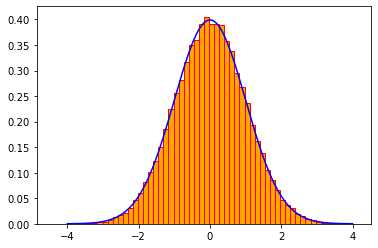

In [47]:
plt.hist(bm_temp[0], bins=60, density = True, color = "orange", edgecolor='red')
x_val = np.linspace(-4,4,10**6)
plt.plot(x_val, norm_pdf(x_val), color = "blue")
#plt.savefig("Z_1.png")

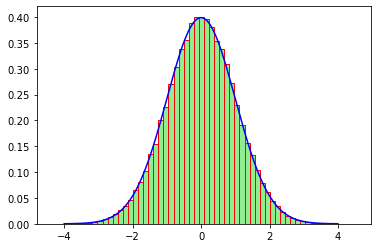

In [48]:
plt.hist(bm_temp[1], bins=60, density = True, color = "lightgreen", edgecolor='red')
x_val = np.linspace(-4,4,10**6)
plt.plot(x_val, norm_pdf(x_val), color = "blue")
#plt.savefig("Z_2.png")

### Matrices

#### Determinant

In [49]:
def matrix_det(A):
    """
    Input: nxn matrix / array
    ------------------------------------------------
    Convert matrix into a upper triangle matrix
    then return the product of the diagonal elements
    (gives determinant)
    ------------------------------------------------
    source: 
    https://integratedmlai.com/find-the-determinant-of-a-matrix-with-pure-python-without-numpy-or-scipy/
    """
    
    
    # Establish n parameter and copy A
    A = np.array(A)
    n = A.shape[0]
    C = A.copy() # copy
    
    # check if A is a square matrix. 
    if A.shape[0] != A.shape[1]:
        raise ValueError("This is not a square matrix!")
 
    # Row ops on A to get in upper triangle form
    for d in range(n): 
        for i in range(d+1,n): #
            if C[d][d] == 0: # Nice trick to avoid dividing by zero (just in case!)
                C[d][d] == 1.0e-18
            
            # 
            coef = C[i][d] / C[d][d] 
            # Element / element operation
            #need to review for array operation?
            for j in range(n): 
                C[i][j] = C[i][j] - coef * C[d][j]
     
    # Section 3: Once AM is in upper triangle form ...
    prod = 1.0
    for i in range(n):
        # ... product of diagonals is determinant
        prod *= C[i][i] 
    return prod

#### Cholesky decomposition

In [27]:
def cholesky(A):
    """
    Implementation: Cholesky-Banachiewicz Algorithm
    Input  symmetric and positive definite matrix. The function
    returns the lower variant triangular matrix, L.
    -----------------------------------------------------------
    Source: https://www.quantstart.com/articles/Cholesky-Decomposition-in-Python-and-NumPy/
    
    """
    n = len(A)

    # Create zero matrix for L
    L = np.zeros((n,n))

    # Perform the Cholesky decomposition
    for i in range(n):
        for k in range(i+1):
            temp = sum(L[i][j] * L[k][j] for j in range(k))
            
            if (i == k): # Diagonal elements
                # l_{kk} 
                L[i][k] = np.sqrt(A[i][i] - temp)
            else:
                #l_{ik} = 
                L[i][k] = (1.0 / L[k][k] * (A[i][k] - temp))
    return L
 

### Numerical Methods

Few methods to find the zero of a function

#### Bisection method

In [51]:
def bisection(f, a, b, tol=1e-8, maxiter=100):
    """
    Input: 
    f: The function to solve
    a: The x-axis value where f(a)<0
    b: The x-axis value where f(b)>0
    tol: The precision of the solution
    maxiter: Maximum number of iterations
    --------------------------------------------
    Condition: a<b 
               f(a)< 0 < f(b)
            OR f(a)> 0 > f(b)
    Function needs to be monotonic increasing on the interval
    -------------------------------------------
    Output: x value such that f(x) = 0 += tol,
            number of iterations used
    """
    c = (a+b)*0.5 # Declare c as the midpoint ab
    n = 1 # Start with 1 iteration
    while n <= maxiter:
        c = (a+b)*0.5
        if f(c) == 0 or abs(a-b)*0.5 < tol:
            # Root is found or is very close
            return c, n
        n += 1
        if f(c) < 0:
            a = c
        else:
            b = c
    return c, n 

#### Secant method

In [52]:
def secant(f, a, b, tol=1e-8, maxiter=100):
    """
    f: The function to solve
    a: Initial guess
    b: Initial s.t. where b>a
    tol: The precision of the solution
    maxiter: Maximum number of iterations
    --------------------------------------------
    Condition: a<b 
               f(a)< 0 < f(b)
            OR f(a)> 0 > f(b)
    Function needs to be monotonic increasing on the interval
    -------------------------------------------
    Output: x value such that f(x) = 0 += tol,
            number of iterations used
    output: The x-axis value of the root,
    number of iterations used
    """
    n = 1
    while n <= maxiter:
        c = b - f(b)*((b-a)/(f(b)-f(a))) # the small (b-a) is the closer the right bracket is close to f'(x)
        if abs(c-b) < tol:
            return c, n
        a = b
        b = c
        n += 1
        return None, n

#### Newton's method

In [53]:
def newton(f, df, x, tol=1e-8, maxiter=100):
    """
    f: The function to solve
    df: The derivative function of f
    x: Initial guess value of x
    tol: The precision of the solution
    maxiter: Maximum number of iterations
    ---------------------------------------
    output: x value s.t.: f(x) = 0
            number of iterations used
    ---------------------------------------
    NB: Compare to other method, we require df
    """
    n = 1
    while n <= maxiter:
        x1 = x - f(x)/df(x)
        if abs(x1 - x) < tol: # Root is very close
            return x1, n
        else:
            x = x1
            n += 1
    return None, n 

#### Integral - Trapezium

In [54]:
def trapezium(f, a,b, n):
    """
    Trapezium rule for integration
    f: function
    a: lower bound
    b: upper bound
    n: number of interval (higher n, the more accurate)
    """
    h = (b-a)/n
    
    x_axis =  np.linspace(a, b, n+1)
    y_axis = f(x_axis)
    return (h/2) * (y_axis[0] + y_axis[-1] + 2*np.sum(y_axis[1:-1]))

### Linear Interpolation

In [28]:
def linear_interpolation(x,y, t):
    
    """
    1D interpolation
    ------------------------------------------------
    x: array
    y: array
    t: point
    
    to review (different implementation to check speed)
    """
    
    
    x, y = np.array(x).reshape(-1,1), np.array(y).reshape(-1,1)

    # Get the neighbor values
    t1 =np.amax(x[x<=t], initial=x.min())
    t2= np.amin(x[t<=x], initial = x.max())
    

    if t in x:
    
        return y[np.where(x==t)[0][0]]
    # Interpolate the values

    return y[np.where(x==t1)[0][0]] + (y[np.where(x==t2)[0][0]]-y[np.where(x==t1)[0][0]])/(x[np.where(x==t2)[0][0]]-x[np.where(x==t1)[0][0]])* (t-x[np.where(x==t1)[0][0]])

In [29]:
zcb(0.5546)

array([0.98845264])

# Calculation

## correlation

In [30]:
SIGMA_s = corr_matrix(u_hat, kind= "s") # Spearmans' rho
SIGMA_t = corr_matrix(u_hat, kind= "t") # Kendall's tau
SIGMA_p = corr_matrix(u_hat, kind= "p") # Pearson's rho

## Survival Probability / Hazard Rate

In [31]:
def probability(maturity, spread, DF, RR = 0.4):
    
    """
    JPM Implementation: 
    Maturity: in year np.array / list
    Spread: array / list of CDS spread
    DF: Discount Factor: np.array / list
    RR: Recovery Rate (float)
    --------------------------------------
    Return: survival probability and hazard rate.
    """
    
    
    maturity = np.array(maturity, dtype = np.float)
    if maturity[0]!=0:
        maturity = np.append([0], maturity)
    

     

    dt = np.append([0],np.diff(maturity)) 
    
    #Spread
    spread = np.array(spread)
    if spread[0] != 0.0:
        spread = np.append([0], spread)
    if spread[1] > 1.0:
        spread = spread/10000 # convert spread into decimals
    
    n = len(maturity)

    
    DF = np.array(DF)
    survival = np.zeros(n)
    survival[0] = 1.0
    
    
    
    # Loss Rate = (1 - Recovery Rate)
    L = (1-RR)
    
    
    # i=1
    #survival[1] = (L-0.5*spread[1] *dt[1])/ (0.5*spread[1] *dt[1] + L) # for accrued n = 1 
    survival[1] = L/ (spread[1] *dt[1] + L) 
    

    for i in range(2,n):

        # List comprehension to improve speed
        # S (Summation Term)
        S = [DF[j] * (L * survival[j-1] - \
                          (L + dt[j] * spread[i])* \
                           survival[j]) for j in range(1,i)]
        
            
        denominator = DF[i]*( L +dt[i]*spread[i])
        last = (L*survival[i-1] / ( L + dt[i] * spread[i]))


        survival[i] = sum(S) / denominator + last
    
    
    lambdas = np.zeros(len(survival))

    for i in range(1, len(survival)):
        lambdas[i] = -1 / dt[i] * np.log(survival[i] / survival[i-1])
        
    

    return survival, lambdas
        
    

In [32]:
mat = list(cds_spread.columns)[:6]
discount_factor = discounts[discounts["T"].isin([0, 1, 2, 3, 4, 5])].set_index("T").loc[:,"DF"]


# Create a dictionnary:
basket_data = {}
for name in names:
    surv = []
    lbd = []
    cds = cds_spread.loc[name,:]
    surv, lbd = probability(mat, cds, discount_factor, 0.4)
    basket_data[name] = np.array([mat, surv, lbd])

In [33]:
basket_data["ALLY"].shape

(3, 6)

each dictionnary "value" contains a 3 x n array. 
- index 0 : Maturity
- index 1: Survival probability
- index 2: Lambda / Hazard rate

In [34]:
mats = []
lambdas = []
survivals = []
for i in basket_data:
    mats.append(basket_data[i][0][:6])
    survivals.append(basket_data[i][1][:6])
    lambdas.append(basket_data[i][2][:6])
mats = np.array(mats, dtype = np.float)
survivals = np.array(survivals, dtype = np.float)
lambdas = np.array(lambdas, dtype = np.float)

In [35]:
basket_data["ALLY"].shape

(3, 6)

## Log likelihood

In [36]:
def gaussian_copula(u, SIGMA):
    """
    Gaussian copula density function:
    ---------------------------------
    u    : nx1 array: unif R.V
    SIGMA: nxn array: Correlation matrix
    """
    u = np.array(u).reshape(-1,1)
    n = u.shape[0]
    A = 1 / det(SIGMA)**0.5
    B = ((norm_inv_v(u).T).dot(inv(SIGMA) - np.eye(n))).dot(norm_inv_v(u))
    return A * np.exp(-0.5 * B)

In [37]:
gaussian_copula(u_hat.iloc[0,:], SIGMA_t )

array([[1.18274241]])

In [38]:
def t_copula_density(u, nu, SIGMA):
    """
    t copula density function: 
    ---------------------------
    u:     nx1 unif R.V. 
    nu:    degree of freedome
    SIGMA: Correlation matrix
    n:     basket size
    ---------------------------
    return: scalar
    """
    u = u.reshape(-1,1)
    nu = np.float(nu)
    n = u.shape[0]
    
    A = 1 / det(SIGMA)**0.5 *(gamma(0.5 * (nu + n)) / gamma(0.5 * nu)) * (gamma(0.5 * nu) / gamma(0.5 * (nu + 1)))**n
    B = (t_student_inv(u, nu).T.dot(inv(SIGMA))).dot(t_student_inv(u, nu)) 
    C =(1 + B / nu)**(-0.5 * (nu + n))
    D = np.array([(1 + t_student_inv(u[i], nu)**2 / nu)**(-0.5 * (nu + 1)) for i in range(n)])

    return A*C / np.prod(D)

In [39]:
def log_likelihood(data, nu, SIGMA):
    L = 0
    for i in range(u_hat.shape[0]):
        L+= np.log(t_copula_density(data[i], nu, SIGMA_s))
    return L
    

In [32]:
#nu_t = []
#log_t = []
for i in range(1,30):
    print("d.f.:", i, "\tlog likelihood:", log_likelihood(np.array(u_hat), i,SIGMA_t)[0])
#    nu_t.append(i)
#   log_t.append(log_likelihood(np.array(u_hat), i,SIGMA_t)[0])

d.f.: 1 	log likelihood: [-389.81190266]
d.f.: 2 	log likelihood: [86.94176129]
d.f.: 3 	log likelihood: [187.58138389]
d.f.: 4 	log likelihood: [222.11848361]
d.f.: 5 	log likelihood: [236.57521003]
d.f.: 6 	log likelihood: [243.07827363]
d.f.: 7 	log likelihood: [245.89619789]
d.f.: 8 	log likelihood: [246.82963132]
d.f.: 9 	log likelihood: [246.73794156]
d.f.: 10 	log likelihood: [246.06897819]
d.f.: 11 	log likelihood: [245.07161352]
d.f.: 12 	log likelihood: [243.89083898]
d.f.: 13 	log likelihood: [242.61407578]
d.f.: 14 	log likelihood: [241.29529962]
d.f.: 15 	log likelihood: [239.96831265]
d.f.: 16 	log likelihood: [238.65437911]
d.f.: 17 	log likelihood: [237.36678427]
d.f.: 18 	log likelihood: [236.113642]
d.f.: 19 	log likelihood: [234.8996692]
d.f.: 20 	log likelihood: [233.72733187]
d.f.: 21 	log likelihood: [232.59759893]
d.f.: 22 	log likelihood: [231.51044545]
d.f.: 23 	log likelihood: [230.46519265]
d.f.: 24 	log likelihood: [229.46073982]
d.f.: 25 	log likelihood: [2

In [529]:
nu_t = pd.DataFrame(nu_t)
log_t = pd.DataFrame(log_t)
log_like = pd.concat([nu_t, log_t], axis = 1)

In [531]:
log_like.columns = ["DF", "Log_likelihood"]

In [546]:
print(pd.DataFrame(np.array(log_like.iloc[:16,:]).reshape(8,4), columns=["d.f.", "Log likelihood", "d.f.", "Log likelihood"]).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  d.f. &  Log likelihood &  d.f. &  Log likelihood \\
\midrule
0 &   1.0 &     -389.811903 &   2.0 &       86.941761 \\
1 &   3.0 &      187.581384 &   4.0 &      222.118484 \\
2 &   5.0 &      236.575210 &   6.0 &      243.078274 \\
3 &   7.0 &      245.896198 &   8.0 &      246.829631 \\
4 &   9.0 &      246.737942 &  10.0 &      246.068978 \\
5 &  11.0 &      245.071614 &  12.0 &      243.890839 \\
6 &  13.0 &      242.614076 &  14.0 &      241.295300 \\
7 &  15.0 &      239.968313 &  16.0 &      238.654379 \\
\bottomrule
\end{tabular}



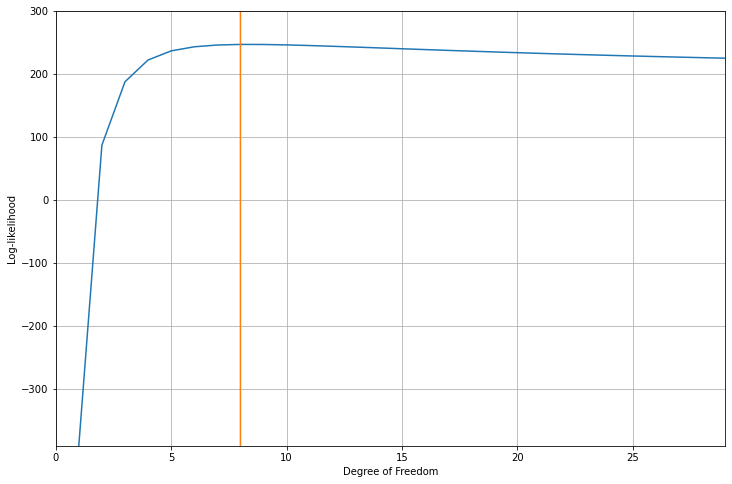

In [508]:
plt.figure(figsize=(12,8))
plt.plot(nu_t, log_t)

# Horizontal line to show max
x = np.array([8.0]*10000)
y = np.linspace(-390, 300, 10000)

plt.grid(True)

plt.xlabel("Degree of Freedom")
plt.ylabel("Log-likelihood")
plt.plot(x,y)
plt.xlim(0,29)
plt.ylim(-390,300)
#plt.savefig(path+"Log_likelihood.png")

In [504]:
print(pd.DataFrame(SIGMA_s).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 \\
\midrule
0 &  1.000000 &  0.645937 &  0.300883 &  0.539762 &  0.674544 \\
1 &  0.645937 &  1.000000 &  0.443272 &  0.550815 &  0.714896 \\
2 &  0.300883 &  0.443272 &  1.000000 &  0.643055 &  0.465899 \\
3 &  0.539762 &  0.550815 &  0.643055 &  1.000000 &  0.575293 \\
4 &  0.674544 &  0.714896 &  0.465899 &  0.575293 &  1.000000 \\
\bottomrule
\end{tabular}



## Basket CDS

In [239]:
class Basket:
    """
    Basket k'th to default
    """
    def __init__(self, SIGMA, survivals, lambdas, N):
    
        """
        Step 1: Instantiate object with 
                - SIGMA: Correlation matrix
                - Survivals: Probability of survival matrix
                - Lambdas : Hazard rate matrix
                - N : Number of iteration
        
        Step 2: call the method:  get_results()
                param: copula: Sampling methodology used:
                            "g": Gaussian copula
                            "t": t copula
                       nu:   : Degree of freedom
        If Gaussian method is called, nu parameter is ignored.
        ----------------------------------------------


        ----------------------------------------------
        required function:
        cholesky 
        norm_cdf_v
        t_student_cdf
        """
        ########################################################
        # Input parameter
        self.SIGMA = np.array(SIGMA)     # Correlation Matrix
        self.survivals = survivals       # Survival probability
        self.lambdas = np.array(lambdas) # hazard rate
        self.N = int(N)                  # Number or iterations
        
        ########################################################
        
        # Automated parameter
        self.n_asset = self.SIGMA.shape[0] # number of asset
                
            
        # Updatable parameter
        # Cholesky decomposition# Lower triangle
        self.S = np.empty_like(self.SIGMA) 
        
        # Mehtod to run while instantiating object
        self._set_cholesky()
                                           
        # Empty arrays
        ## Random Number array
        self.Z = np.empty((self.N, self.n_asset), dtype=np.float)  # 
        self.U = np.empty_like(self.Z)

        ## Time to default
        self.exact_time_to_default = np.zeros((self.n_asset,0))
        self.year_to_default = np.zeros((self.n_asset,0))

        
        
        # Spreads 
        self.spreads = np.array([])
        
        ######################################################

#         self.start_time = 0                 # Used to keep track of time taken for the function to execute.
#         self.runtime = 0                    # Total time taken.
#         self.df = pd.DataFrame(data=None, columns=["N", "1st",
#                                                    "2nd","3rd",
#                                                    "4th", "5th", 
#                                                   "time"])
    


    
    
    
    
    def get_results(self, copula = "t", nu = 8, RR=0.4):
        """
        Use this method to calculate the spread directly. 
        -------------------------------------------------
                copula: methodology
                string 'g': Gaussian
                       't': t-student
        nu    : int: degree of freedom
        -------------------------------------------------
        Needs to explicitly call RR = 0.4 in the method
        """
        start_time = time.time()
        self._set_copula(copula, nu) # sampling
        self._set_time_to_default()
        self._set_payment_legs(RR)
        
        runtime = (time.time() - start_time)
        return self.N, runtime, self.spreads
    
    

    def _set_copula(self, copula= "t", nu = 7):
        """
        copula: methodology
                string 'g': Gaussian
                       't': t-student
        nu    : int: degree of freedom
        --------------------------------------
        requires: norm_cdf_v
                  t_student_cdf
                  
        --------------------------------------
        nb: fix seed to compare methodologie / params
        """

        #generate N x n_asset random standard Normal variable 
        self.Z = np.random.normal(0, 1, (self.N,self.n_asset))
        
    
        if copula =="g":
            
            # Apply norm CDF to each element of the array 
            #------------------------------
            # NB: I am using numpy.vectorize which is not 
            # the most efficient method but it avoids us
            # using an explicit loop. The alternative was
            # to use the built-in function from scipy 
            #(i.e. import scipy.stats)
            X = self.S.dot(self.Z.T).T
            U = norm_cdf_v(X)
            
        elif copula =="t":
            #  self.copula =="t"
            # Generate a 3D np.array: (N x nu x n Z-R.N)
            # square the input and sum on the 1-axis
            # i.e. if nu = 7, it will add 7 square - r.n
            s = np.sum(np.random.normal(0,1,(self.N,nu, self.n_asset))**2, axis = 1)
            s = np.sqrt(s/nu)
            Y = self.Z/s
            X = self.S.dot(Y.T).T
            U = t_student_cdf(X, nu).reshape(self.N, self.n_asset)
        
        else:
            print("copula method undefined.")
        
        self.U = U
    
    
    def _set_cholesky(self):
        """
        Cholesky decomposition of correlation matrix
        """
        self.S = cholesky(self.SIGMA)

        
    def _set_time_to_default(self):
        ttd = np.zeros((self.n_asset, 0)) # time to default
        ytd = np.zeros((self.n_asset, 0)) # year to default
        for i in range(self.N):
            temp = self._get_time_to_default(self.lambdas,
                                        self.survivals, 
                                        self.U[i:i+1,:][0])
            ttd = np.append(ttd, temp[0])
            ytd = np.append(ytd, temp[1])
            
        
        
        self.exact_time_to_default = ttd.reshape(self.N, self.n_asset)
        self.year_to_default = ytd.reshape(self.N, self.n_asset)
        

                
    
    
    def _set_payment_legs(self, RR= 0.4):
        premium_leg = np.zeros(self.n_asset, dtype = np.float)
        default_leg = np.zeros(self.n_asset, dtype = np.float)
        
        for i in range(self.N):
            
            pl_, dl_ = self._legs_payments(self.exact_time_to_default[i],
                                     self.year_to_default[i],
                                     self.n_asset, RR)
            
            
            premium_leg += pl_
            default_leg += dl_
    
        spreads = np.array(default_leg)/np.array(premium_leg)
        
        self.spreads = spreads
        
        return spreads
    
    
    @staticmethod
    def _legs_payments(default_time,default_year,n_asset, RR = 0.4):
        """
        Legs cash flow:
        ------------------
        input: 
        default_time: 5x1 array 
        default_year: 5x 1 array
        -------------------
        output: 
            Premium leg
            Default leg
        """
        
        
        mat= default_time.shape[0]
        

        # ignore if default time < 0.25 (quaterly)
        for i in range(len(default_time)):
            if default_time[i] <= 0.25: # quaterly
                default_time[i]=9999

        def_order=np.argsort(default_time) #gives index
        
        #number of default
        n_defaults=len(default_year)-np.count_nonzero(default_year== 999)

        
        # array for default / premium leg
        premium_leg=np.zeros(n_asset,dtype= np.float) # premium leg
        default_leg=np.zeros(n_asset,dtype= np.float) # default leg



        if n_defaults ==0:
            for k in range(len(premium_leg)):
                premium_leg[k]=zcb(mat)*mat
                default_leg[k]=0
        else:
            premium_leg_1=0
            tau_1=0
            loss=0
            for i in range(n_defaults):
                     
                tau=default_time[def_order[i]] # The ith default time


                default_leg[i]=zcb(tau)*(1-RR)* (1/n_asset) # Assuming equal weight
                premium_leg[i]=premium_leg_1+(1-loss)*zcb(tau)*(tau-tau_1) 
                loss+=(1/n_asset) # Assuming equal weight
                premium_leg_1=premium_leg[i]
                tau_1=tau
            if  n_defaults < n_asset:
                last_default_time=default_time[def_order[n_defaults-1]]
                non_default_premium=zcb(mat)*(mat-last_default_time)*(1-loss)
                for j in range(n_defaults,n_asset):
                    premium_leg[j]=non_default_premium+premium_leg[n_defaults-1]
                    default_leg[j]=0



        return premium_leg,default_leg



    @staticmethod
    def _get_time_to_default(lambdas,survivals,u):

        """
        1D version (simple)
        """

        
        T = 999 # if cds doesn't default within contract life (i.e. 5y)
                # set an arbitrary large number (trick taken from A. Sehra paper)
    
        default_year=[] #
        dt=[]

        
        for i in range(lambdas.shape[0]):
            flag=0
            
            
            for j in range(lambdas.shape[0]):

                if np.abs(np.log(1-u[i])) < np.sum(lambdas[i,0:j+1]):
                    default_year.append(j)
                    flag=1
                    break
                    
            if flag==0:
                default_year.append(T)

        for i in range(len(default_year)):
            if default_year[i] == T:
                dt.append(T)
            
            else:
                dt.append((-1/lambdas[i][default_year[i]])*np.log((1-u[i])/(survivals[i][default_year[i]])))        

        default_time=np.array(default_year)+np.array(dt)


        return default_time,default_year
    

In [240]:
a = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],10000)
a.get_results(copula="g", nu = 8, RR = 0.1)

(10000,
 10.056386232376099,
 array([5.30247491e-03, 1.35268448e-03, 4.30645774e-04, 1.36884910e-04,
        3.96363995e-05]))

In [434]:
start_time = time.time()

temp = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],600000)
temp.set_copula("t", 8)
temp.set_time_to_default()
temp.set_payment_legs()*10000

print("--- %s seconds ---" % (time.time() - start_time))

--- 4407.264467954636 seconds ---


It takes more than an hour to perform 600,000 simulations

# Monte Carlo

In [174]:
runtime_g= []
spread_g = []
simulation_g= []
sim_list = [100, 1000,5000, 10000,15000, 25000,50000]
sim_list2 = [100000]

for i in sim_list:
    mc = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],i)
    df1 = mc.get_results(copula = "g")
    simulation_g.append(df1[0])
    runtime_g.append(df1[1])
    spread_g.append(df1[2])
    


In [173]:
runtime_t = []
spread_t = []
simulation_t = []
sim_list = [100, 1000, 5000, 10000, 15000, 25000, 50000]
sim_list2 = [100000]
for i in sim_list:
    mc = Basket(SIGMA_s, survivals[:, 1:], lambdas[:, 1:], i)
    df1 = mc.get_results(copula="t", nu=8)
    simulation_t.append(df1[0])
    runtime_t.append(df1[1])
    spread_t.append(df1[2])

In [175]:
print("DONE-==-=--=-=")

DONE-==-=--=-=


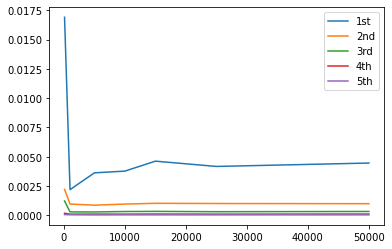

In [141]:
for i in range(len(names)):
    plt.plot(simulation_g, np.array(spread_g)[:,i], label = def_year[i])
    plt.legend()
#plt.savefig(path+"survivals_probability.jpg")

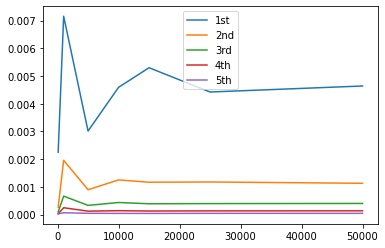

In [142]:
for i in range(len(names)):
    plt.plot(simulation_t, np.array(spread_t)[:,i], label = def_year[i])
    plt.legend()
#plt.savefig(path+"survivals_probability.jpg")

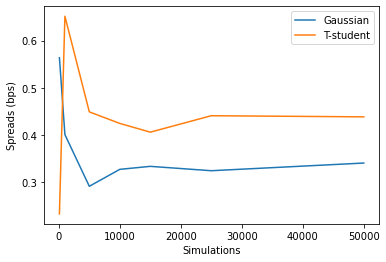

In [159]:
i = 4
plt.plot(simulation_g, np.array(spread_g)[:,i]*10000, label = "Gaussian")
plt.plot(simulation_t, np.array(spread_t)[:,i]*10000, label = "T-student")
plt.xlabel("Simulations")
plt.ylabel("Spreads (bps)")
plt.legend()
plt.savefig(path + str(i+1)+"_to_default.jpg")

In [119]:
def table_spreads(spreadg, spreadt):
    def_year= ["1st", "2nd", "3rd", "4th", "5th"]
    return pd.DataFrame([spreadg[-1]*10000, spreadt[-1]*10000],
                        index=["Gaussian", "t-studend"], columns=def_year)

In [176]:
print(table_spreads(spread_g, spread_t).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &        1st &        2nd &       3rd &       4th &      5th \\
\midrule
Gaussian  &  39.898659 &  10.450172 &  3.176316 &  1.046738 &  0.33840 \\
t-studend &  45.734464 &  11.489605 &  3.812066 &  1.301085 &  0.41096 \\
\bottomrule
\end{tabular}



In [39]:
aaa = pd.DataFrame(columns=["1st", "2nd", "3rd",
                      "4th", "5th", "simulation", "runtime"])

In [113]:
mc = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],10000)

In [114]:
mc.get_results()

(10000,
 9.549064636230469,
 array([4.77803936e-03, 1.12163240e-03, 3.85844631e-04, 1.37959866e-04,
        4.50476670e-05]))

In [448]:
start_time = time.time()
temp1 = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],10000)
temp1.set_copula("t", 8)
temp1.set_time_to_default()
temp1.set_payment_legs()*10000

print("--- %s seconds ---" % (time.time() - start_time))

--- 10.230647325515747 seconds ---


In [568]:
print(pd.DataFrame(lambdas).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &    0 &         1 &         2 &         3 &         4 &         5 \\
\midrule
0 &  0.0 &  0.011449 &  0.028807 &  0.046724 &  0.093833 &  0.131489 \\
1 &  0.0 &  0.006398 &  0.013652 &  0.021074 &  0.033292 &  0.043728 \\
2 &  0.0 &  0.006785 &  0.012798 &  0.018947 &  0.036013 &  0.048394 \\
3 &  0.0 &  0.007462 &  0.018421 &  0.029665 &  0.054878 &  0.074830 \\
4 &  0.0 &  0.005037 &  0.009333 &  0.013719 &  0.034144 &  0.047363 \\
\bottomrule
\end{tabular}



## Sensitive analysis

### Spread Shift

In [60]:
cds_spread

,0.0,1.0,2.0,3.0,4.0,5.0
AAL,0.0,69.09,120.720,172.35,262.375,352.40
ALLY,0.0,38.51,60.035,81.56,109.500,137.44
AMD,0.0,40.85,58.695,76.54,109.495,142.45
AMKR,0.0,44.94,77.475,110.01,161.355,212.70
F,0.0,30.30,43.040,55.78,91.015,126.25


In [161]:
cds_spread.iloc[0,1:]

1.0     69.090
2.0    120.720
3.0    172.350
4.0    262.375
5.0    352.400
Name: AAL, dtype: float64

In [326]:
recovery=0.75

In [327]:
cds_copy = cds_spread.copy()
#cds_copy.iloc[:,1:] = cds_spread.iloc[:,1:]+k
#cds_copy

In [328]:

# Create a dictionnary:
basket_data = {}
for name in names:
    surv = []
    lbd = []
    cds = cds_copy.loc[name,:]
    surv, lbd = probability(mat, cds, discount_factor, recovery)
    basket_data[name] = np.array([mat, surv, lbd])

In [329]:
mats = []
lambdas = []
survivals = []
for i in basket_data:
    mats.append(basket_data[i][0][:6])
    survivals.append(basket_data[i][1][:6])
    lambdas.append(basket_data[i][2][:6])
mats = np.array(mats, dtype = np.float)
survivals = np.array(survivals, dtype = np.float)
lambdas = np.array(lambdas, dtype = np.float)

In [330]:
a = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],25000)
a.get_results(copula="g", nu = 8, RR=recovery)

b = Basket(SIGMA_s, survivals[:,1:],lambdas[:,1:],25000)
b.get_results(copula="t", nu = 8, RR=recovery)

(25000,
 30.12312150001526,
 array([2.05070934e-03, 4.87863099e-04, 1.69691502e-04, 6.00121745e-05,
        2.31265178e-05]))

delta_cds = []
result_g = []
result_t = []

In [331]:
delta_cds.append(recovery)
result_g.append(a.spreads)
result_t.append(b.spreads)

In [332]:
delta_cds

[0, 0.25, 0.5, 0.75, 1.0, 0.75]

In [333]:
result_t

[array([5.39363489e-03, 1.53815894e-03, 5.50141358e-04, 1.82909280e-04,
        5.86345070e-05]),
 array([6.15413458e-03, 1.35316904e-03, 4.71788254e-04, 1.54826355e-04,
        5.02425264e-05]),
 array([3.95963012e-03, 1.10102191e-03, 3.50050221e-04, 1.14195431e-04,
        3.75098738e-05]),
 array([1.99623021e-03, 5.04296413e-04, 1.78004243e-04, 6.28834718e-05,
        2.32355761e-05]),
 array([nan, nan, nan, nan, nan]),
 array([2.05070934e-03, 4.87863099e-04, 1.69691502e-04, 6.00121745e-05,
        2.31265178e-05])]

In [334]:
n =-1
tbl = pd.DataFrame([result_g[n]*10000, result_t[n]*10000] , index=["Gaussian", "t-studend"], columns=def_year)
#tbl.index.name = "$\Delta$"+str(delta_cds[n])
print(tbl.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &        1st &       2nd &       3rd &       4th &       5th \\
\midrule
Gaussian  &  26.723925 &  5.258950 &  1.611037 &  0.558953 &  0.210419 \\
t-studend &  20.507093 &  4.878631 &  1.696915 &  0.600122 &  0.231265 \\
\bottomrule
\end{tabular}



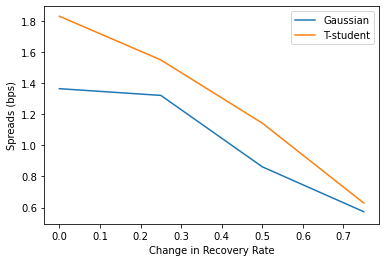

In [342]:
i = 3
plt.plot(delta_cds, np.array(result_g)[:,i]*10000, label = "Gaussian")
plt.plot(delta_cds, np.array(result_t)[:,i]*10000, label = "T-student")
plt.xlabel("Change in Recovery Rate")
plt.ylabel("Spreads (bps)")
plt.legend()
plt.savefig(path + str(i+1)+"_recovery_rate.jpg")

In [337]:
np.array(result_g)[:,0]

array([0.00574428, 0.00463142, 0.00347534, 0.00289927,        nan,
       0.00267239])

In [338]:
result_g

[array([5.74427812e-03, 1.41978307e-03, 4.50687824e-04, 1.36362692e-04,
        4.33824125e-05]),
 array([4.63142488e-03, 1.34426044e-03, 4.01274233e-04, 1.32041202e-04,
        3.94368875e-05]),
 array([3.47533899e-03, 8.36082856e-04, 2.56643986e-04, 8.61528628e-05,
        3.04274667e-05]),
 array([2.89926684e-03, 5.61650939e-04, 1.63377338e-04, 5.72973961e-05,
        2.09837990e-05]),
 array([nan, nan, nan, nan, nan]),
 array([2.67239250e-03, 5.25894991e-04, 1.61103713e-04, 5.58952921e-05,
        2.10419238e-05])]

In [186]:
cds_spread_1.iloc[0,:]+100

0.0    100.000
1.0    169.090
2.0    220.720
3.0    272.350
4.0    362.375
5.0    452.400
Name: AAL, dtype: float64

# Plot

## survivals probability plot

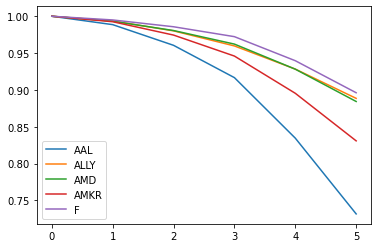

In [110]:
for i in range(survivals.shape[0]):
    plt.plot(np.arange(0,6,1), survivals[i], label = names[i])
    plt.legend()
plt.savefig(path+"survivals_probability.jpg")

In [ ]:
print(pd.DataFrame(survivals[:,1:], columns=names).T.to_latex())

## Hazard Rate plot

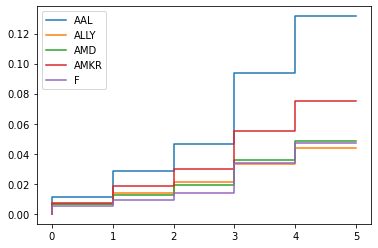

In [109]:
for i in range(lambdas.shape[0]):
    plt.step(np.arange(0,6,1), lambdas[i], label = names[i])
    plt.legend()
plt.savefig(path+"Hazard_rate.jpg")

In [111]:
print(pd.DataFrame(lambdas[:,1:], columns=names).T.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &         0 &         1 &         2 &         3 &         4 \\
\midrule
AAL  &  0.011449 &  0.006398 &  0.006785 &  0.007462 &  0.005037 \\
ALLY &  0.028807 &  0.013652 &  0.012798 &  0.018421 &  0.009333 \\
AMD  &  0.046724 &  0.021074 &  0.018947 &  0.029665 &  0.013719 \\
AMKR &  0.093833 &  0.033292 &  0.036013 &  0.054878 &  0.034144 \\
F    &  0.131489 &  0.043728 &  0.048394 &  0.074830 &  0.047363 \\
\bottomrule
\end{tabular}

